# Тестовое задание Контур

## Оглавление:

* [Постановка задачи](#target_setting)
* [Подключение библиотек](#load_libs)
* [Используемые константы](#used_constants)
* [Используемые функции](#used_functions)
* [Загрузка исходных данных](#load_data)
    * [Пути к директориям и файлам](#path_data)
    * [Загрузка данных](#load_dataset)    
* [Анализ данных (Exploratory Data Analysis (EDA))](#eda)
    * [Обзор данных](#data_overview)
    * [Обзор целевой переменной](#target_feature_overview)
    * [Определение длины текстового сообщения и % знаков препинания в тексте](#len_punct)
    * [Построение "облака слов"](#word_cloud)    
* [Предварительная обработка данных](#data_preprocessing)
    * [Проверка орфографии в датасете](#spelling_check)
    * [Очиcтка текста приведение слов к стандартному виду](#text_clearing) 
* [Векторное представление текста](#vector_representation)
    * [Разделение df_train на train и test](#train/test_split)
    * [Bag of words (BOW)](#bow)
    * [TF-IDF](#tfidf)
    * [Bag of words (BOW) с биграммами](#bow_bi) 
* [Построение моделей](#modeling)
    * [На данных BOW](#modeling_bow)
    * [На данных TF-IDF](#modeling_tfidf)
    * [На данных BOW с биграммами](#modeling_bow_bi)
    * [Объединение результатов, выбор лучшей модели](#stata_combined)
* [Подбор гиперпараметров и отбор фичей](#selection_hyperparameters_and_features)
    * [Отбор фичей](#selection_features)
    * [Подбор оптимального размера выборки, кривая обучения](#learning_curve)
    * [Подбор гиперпараметров](#selection_hyperparameters)
    * [Построение финальной модели](#final_model)
    * [Сохранение финальной модели](#final_model_saving)
* [Прогнозирование на тестовом датасете](#forecasting_test_dataset)
    * [Подготовка тестовых данных](#test_dataset_processing)
    * [Прогноз](#forecast)
    * [Сохранение результатов](#saving_results) 
* [Итоги работы](#results)

## Постановка задачи<a class="anchor" id="target_setting"></a>

**Задание**

Для выполнения тестового задания требуется разработать модель, которая будет способна различать заголовки реальных и выдуманных новостей. Для обучения модели используйте данные из файла train.tsv. В файле находится таблица, состоящая из двух колонок. В колонке title записан заголовок новости. В колонке is_fake содержатся метки: 0 – новость реальная; 1 – новость выдуманная. Для демонстрации работы модели используйте данные тестового набора из файла test.tsv. В нем также есть колонка title, данные которой являются входными для вашей модели. Вам нужно скопировать файл test.tsv, переименовать его в predictions.tsv и заполнить колонку is_fake значениями предсказаний вашей модели, аналогично train.tsv. Изначально колонка заполнена значением 0.

**Критерии оценки**

Для оценки финального решения будет использоваться метрика F1 score.
Чистота кода, оформление и понятность исследования.

**Требования к решению**

В качестве решения мы ожидаем zip-архив со всеми .py и .ipynb файлами в папке solution и файлом predictions.tsv в корне. Формат имени zip-архива: LastName_FirstName.zip (пример Ivanov_Ivan.zip). Файл predictions.tsv должен включать в себя колонку title, содержащую те же данные, что и исходный файл test.tsv, а также колонку is_fake, содержащую значения 0 или 1. Разметка тестового набора данных и включение его в обучение/валидацию запрещены.

В папке solution должно быть отражено исследование и весь код, необходимый для воспроизведения исследования.

## Подключение библиотек<a class="anchor" id="load_libs"></a>

**Используемые библиотеки**

In [1]:
# !pip install xgboost
# !pip install lightgbm
# !pip install catboost
# !pip install imbalanced-learn
# !pip install wordcloud
# !pip install pymorphy2
# !pip install pyaspeller

In [2]:
# Libraries for working with paths and saving
from pathlib import Path
# import os
import pickle

# Scientific libraries
import numpy as np
import pandas as pd
import re

# Visual libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})
plt.style.use('seaborn')

# Scikit-learn libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV, learning_curve
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel



# Language libraries
from wordcloud import WordCloud, STOPWORDS
import pymorphy2
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
# nltk.download('stopwords')
from nltk.corpus import stopwords
import string
from pyaspeller import YandexSpeller

import xgboost as xgb
import catboost as catb
import inspect

In [3]:
# print(f'Версия xgboost: {xgb.__version__}')
# !python --version

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Используемые константы<a class="anchor" id="used_constants"></a>

In [5]:
# Список используемых переменных констант

RANDOM_STATE = 42

## Используемые функции<a class="anchor" id="used_functions"></a>

In [6]:
# получение списка всех слов в корпусе

def get_news(data):
    news = []
    for phrase in data:
        for word in phrase.split():
            news.append(word)
    return news

In [7]:
# получение текстовой строки из списка слов

def str_news(news):
    str_news = ''
    for i in news:
        str_news += ' ' + i
    str_news = str_news.strip()
    return str_news

In [8]:
# получение облака слов

def get_word_cloud(news):
    word_cloud = WordCloud(background_color='white',
                              stopwords=STOPWORDS,
                              width=3000,
                              height=2500,
                              max_words=200,
                              random_state=RANDOM_STATE
                         ).generate(str_news(news))
    return word_cloud

In [9]:
# функция проверки орфографии

speller = YandexSpeller()

def get_spelling_check_text(text):
    changes = {change['word']: change['s'][0] for change in speller.spell(text)}
    for word, suggestion in changes.items():
        text = text.replace(word, suggestion)
        
    return text

In [10]:
# функция предварительной очистки, включая удаление стоп-слов и лемматизацию и/или стемминг

ru_stopwords = set(stopwords.words('russian'))

# предварительная обработка текста

def get_text_preprocessing(text):
    reg = re.compile('[^а-яА-яa-zA-Z0-9 ]')
    text = text.lower()
    text = text.replace('ё', 'е')
    text = text.replace("ъ", "ь")
    text = text.replace("й", "и")
    text = reg.sub(' ', text)
    
    # Лемматизация + удаление стоп слов
    morph = pymorphy2.MorphAnalyzer()
    # text =[morph.parse(word)[0].normal_form for word in text.split()]
    text = ' '.join([morph.parse(word)[0].normal_form for word in text.split() if word not in ru_stopwords])
    
    # # Стемминг + удаление стоп слов
    # stemmer = SnowballStemmer('russian')
    # # text = [stemmer.stem(word) for word in text.split()]
    # text = ' '.join([stemmer.stem(word) for word in text.split() if word not in ru_stopwords])              
     
    return text

In [11]:
# функция, задающая список моделей

def init_models():
    model_lr = LogisticRegression(random_state=RANDOM_STATE)
    model_sgd = SGDClassifier(random_state=RANDOM_STATE)
    model_knb = KNeighborsClassifier()
    model_rf = RandomForestClassifier(random_state=RANDOM_STATE)
    model_xgb = xgb.XGBClassifier(random_state=RANDOM_STATE)   

    models = {
        'lr': model_lr,
        'sgd': model_sgd,
        'knb': model_knb,
        'rf': model_rf,
        'xgb': model_xgb,        
    }
    return models

In [12]:
# функция для расчёта метрик

def get_metrics(report):
    f1_macro = report['macro avg']['f1-score']
    f1_0 = report['0']['f1-score']
    f1_1 = report['1']['f1-score']
    return f1_macro, f1_0, f1_1

In [13]:
# функция для вывода отчетов классификации (общий вид)

def run_experiment(X_train, X_test, y_train, y_test, vector=' '):   
    
    models = init_models()
    
    stata = pd.DataFrame()    
    for name, model in models.items():
        model.fit(X_train, y_train)
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)

        report_train = classification_report(y_train, pred_train, output_dict=True)
        report_test = classification_report(y_test, pred_test, output_dict=True)
        f1_macro_train, f1_0_train, f1_1_train = get_metrics(report_train)
        f1_macro_test, f1_0_test, f1_1_test = get_metrics(report_test)

        stata = stata.append({
            'model_name': name,
            f'f1_macro_train_{vector}': f1_macro_train,
            f'f1_macro_test_{vector}': f1_macro_test,
            f'f1_0_train_{vector}': f1_0_train,
            f'f1_0_test_{vector}': f1_0_test,
            f'f1_1_train_{vector}': f1_1_train,
            f'f1_1_test_{vector}': f1_1_test
            }, ignore_index=True)
    return stata, models

In [14]:
# функция для вывода отчета классификации (частный вид)

def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred)) #подсчет классификации для train
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred)) #подсчет классификации для test
    print('CONFUSION MATRIX\n') #матрица ошибок
    print(pd.crosstab(y_test_true, y_test_pred))

In [15]:
# функция подсчета предсказаний и вывода отчетов классификации на обучении и тесте (частный вид)
 
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train) # подсчет предсказаний  на train
    y_test_pred = model.predict(X_test) # подсчет предсказаний  на test
    
    get_classification_report(y_train, y_train_pred, y_test, y_test_pred) # вывод отчета классификации

In [16]:
# функция показывает зависимости метрики от разного количества объектов

def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)): 

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

## Загрузка исходных данных<a class="anchor" id="load_data"></a>

### Пути к директориям и файлам<a class="anchor" id="path_data"></a>

In [17]:
DATA_ROOT = Path('../')
MODELS_PATH = Path('../2_models/')

# input
TRAIN_DATASET_PATH = DATA_ROOT / '1_input_data/train.tsv'
TEST_DATASET_PATH = DATA_ROOT / '1_input_data/test.tsv'

# output
PREP_DATASET_PATH = DATA_ROOT / '3_work/df_train_prepared.csv'
PRED_PREP_DATASET_PATH = DATA_ROOT / '3_work/df_test_prepared.csv'
ORTHO_DATASET_PATH = DATA_ROOT / '3_work/df_train_orthographic.csv'
PRED_ORTHO_DATASET_PATH = DATA_ROOT / '3_work/df_test_orthographic.csv'
SUBMISSION_PATH = DATA_ROOT / '../predictions.tsv'

MODEL_FILE_PATH = MODELS_PATH / 'model.pkl'

### Загрузка данных<a class="anchor" id="load_dataset"></a>

**Описание базового датасета**

* **title** - заголовок новости
* **is_fake** - метка: 0 – новость реальная; 1 – новость выдуманная

In [18]:
df_train = pd.read_csv(TRAIN_DATASET_PATH, sep='\t')
df_train.head()

,title,is_fake
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1
1,Агент Кокорина назвал езду по встречке житейск...,0
2,Госдума рассмотрит возможность введения секрет...,1
3,ФАС заблокировала поставку скоростных трамваев...,0
4,Против Навального завели дело о недоносительст...,1


In [19]:
df_test = pd.read_csv(TEST_DATASET_PATH, sep='\t')
df_test.head()

,title,is_fake
0,Роскомнадзор представил реестр сочетаний цвето...,0
1,Ночью под Минском на президентской горе Белара...,0
2,Бывший спичрайтер Юрия Лозы рассказал о трудно...,0
3,"Сельская церковь, собравшая рекордно низкое ко...",0
4,Акции Google рухнули после объявления о переза...,0


In [20]:
print('Тренировочный датасет df_train:', df_train.shape)
print('Тестовый датасет df_test:', df_test.shape)

Тренировочный датасет df_train: (5758, 2)
Тестовый датасет df_test: (1000, 2)


## Анализ данных (Exploratory Data Analysis (EDA))<a class="anchor" id="eda"></a>

### Обзор данных<a class="anchor" id="data_overview"></a>

In [21]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5758 entries, 0 to 5757
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    5758 non-null   object
 1   is_fake  5758 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.1+ KB


In [22]:
pd.DataFrame(df_train['title'].value_counts())

,title
В США зафиксировано рекордное количество банкротств,2
Москвичу Владимиру Клутину пришёл счёт за вмешательство в американские выборы,1
Немцы очистят российский воздух,1
Началась приватизация Объединенной зерновой компании,1
Командующий РВСН планирует заняться разработкой Булавы,1
...,...
В честь Дня города в Москве откроют новый миграционный центр,1
"Россияне, ушедшие в отпуск в конце декабря, лишатся новогодних каникул",1
Кредиторы Сибири остановили ее слияние с Внуковскими авиалиниями,1
«Рутениевое кольцо»: в России появится сеть туристических маршрутов по самым экологически загрязнённым местам,1


In [23]:
df_train.loc[df_train['title'] == 'В США зафиксировано рекордное количество банкротств']

,title,is_fake
402,В США зафиксировано рекордное количество банкр...,0
624,В США зафиксировано рекордное количество банкр...,0


**Вывод:** Пропуски в df_train отсутствуют. Есть повторяющиеся новости под номером 402 и 624

In [24]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    1000 non-null   object
 1   is_fake  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [25]:
pd.DataFrame(df_test['title'].value_counts())

,title
"Роскомнадзор представил реестр сочетаний цветов, нежелательных в России",1
Тренер Челси нашел причину неудач Фернандо Торреса,1
Совершена попытка захвата Братского лесокомбината,1
"Россиян, не желающих вакцинироваться от коронавируса, будут депортировать в страны Евросоюза",1
Верховный суд подтвердил право граждан СССР на получение бесплатных квартир,1
...,...
Еврокомиссар назвал российский газовый сектор неподходящим для санкций,1
Киев обратился к ЮНЕСКО с просьбой получить право называть борщ украинским,1
МВД пообещало 8 марта не реагировать на все сообщения о домашнем насилии женщин в отношении мужчин,1
Иллюстрации к книгам про Винни Пуха выставят на аукцион,1


**Вывод:** Пропуски в df_test отсутствуют

### Обзор целевой переменной<a class="anchor" id="target_feature_overview"></a>

**is_fake** - метка, характеризующая реальность новости.  
Имеет значения:  
0 – новость реальная;  
1 – новость выдуманная

In [26]:
df_train['is_fake'].value_counts()

1    2879
0    2879
Name: is_fake, dtype: int64

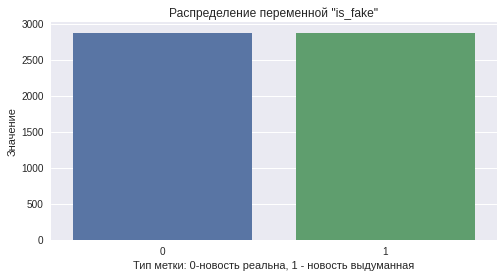

In [27]:
counts = df_train['is_fake']. value_counts()

plt.figure(figsize=(8,4))
plt.title('Распределение переменной "is_fake"')
sns.barplot(counts.index, counts.values)
plt.xlabel('Тип метки: 0-новость реальна, 1 - новость выдуманная')
plt.ylabel('Значение')
plt.show()

**Вывод:** Целевая переменная is_fake сбалансирована по классам. Пропуски и выбросы отсутствуют.

### Определение длины текстового сообщения и % знаков препинания в тексте<a class="anchor" id="len_punct"></a>

In [28]:
# функция для вычисления длины заголовка новости без учета пробелов
df_train['title_len'] = df_train['title'].apply(lambda x: len(x) - x.count(" "))

# функция показывает процент знаков препинания в теле заголовка новости
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

df_train['punct%'] = df_train['title'].apply(lambda x: count_punct(x))

df_train.head()

,title,is_fake,title_len,punct%
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1,68,0.0
1,Агент Кокорина назвал езду по встречке житейск...,0,50,0.0
2,Госдума рассмотрит возможность введения секрет...,1,68,0.0
3,ФАС заблокировала поставку скоростных трамваев...,0,51,0.0
4,Против Навального завели дело о недоносительст...,1,52,0.0


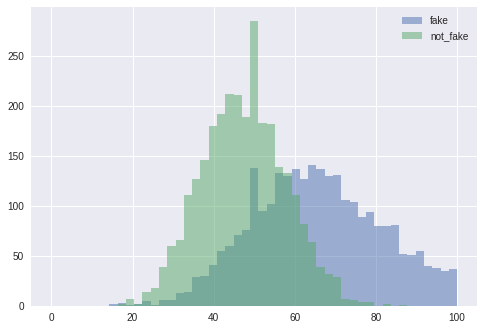

In [29]:
bins = np.linspace(0, 100, 50)

plt.hist(df_train[df_train['is_fake'] == 1]['title_len'], bins, alpha=0.5, label='fake')
plt.hist(df_train[df_train['is_fake'] == 0]['title_len'], bins, alpha=0.5, label='not_fake')
plt.legend(loc='upper right')
plt.show()

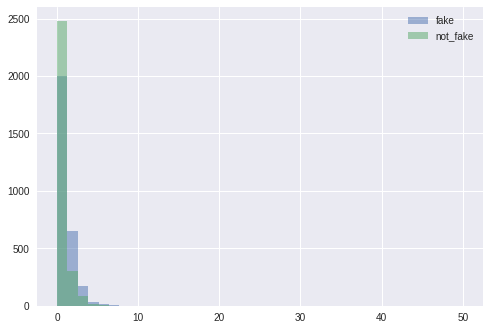

In [30]:
bins = np.linspace(0, 50, 40)

plt.hist(df_train[df_train['is_fake'] == 1]['punct%'], bins, alpha=0.5, label='fake')
plt.hist(df_train[df_train['is_fake'] == 0]['punct%'], bins, alpha=0.5, label='not_fake')
plt.legend(loc='upper right')
plt.show()

### Построение "облака слов"<a class="anchor" id="word_cloud"></a>

In [31]:
news = get_news(df_train['title'].values)
cloud = get_word_cloud(news)

<AxesSubplot:>

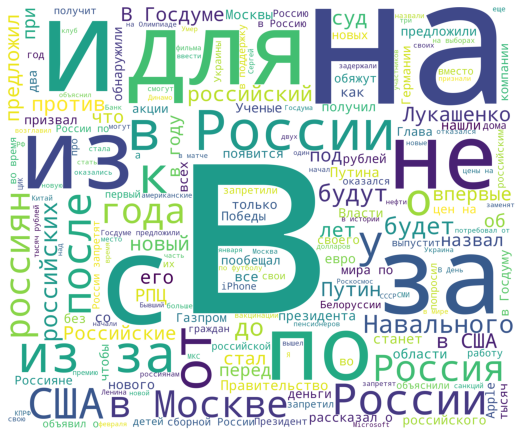

In [32]:
fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(cloud)
plt.axis('off')
plt.subplot(1, 2, 1)

In [33]:
# Количество уникальных слов в тексте
num_words = len(set(news))
print(f'Количество уникальных слов в исходном тексте: {num_words}')

Количество уникальных слов в исходном тексте: 20701


**Общий вывод:**   
Исходный датасет имеет 5758 строк, не содержит пропусков. Количество уникальных слов в исходном тексте 20701. Есть один повтор в строках 402 и 624, что маловероятно может сказаться на конечном результате, т.к. соответствующее данным строкам значение 'is_fake' одинаковое.  
Анализ длины заголовков новостей показал, что выдуманные новости имеют большую длины, чем реальные.  
Анализ процента знаков препинания значимых результатов не дал.   
Построение «облака слов» позволило визуально определить наиболее часто встречающиеся слова. Есть необходимость дополнительной очистки текстов от «мусора», не несущего смысловой нагрузки, а также, знаков препинания

## Предварительная обработка данных<a class="anchor" id="data_preprocessing"></a> 

### Проверка орфографии в датасете<a class="anchor" id="spelling_check"></a> 

In [34]:
# print(inspect.getsource(get_spelling_check_text))

In [35]:
%%time 

df_train['title_clean'] = df_train['title'].apply(get_spelling_check_text)

CPU times: user 2min 39s, sys: 7.08 s, total: 2min 46s
Wall time: 11min 44s


In [36]:
# Сохраним вариант датасета df_train с проверенной орфографией (процедура очень долгая)
df_train.to_csv(ORTHO_DATASET_PATH, index=False, encoding='utf-8')

### Очиcтка текста приведение слов к стандартному виду<a class="anchor" id="text_clearing"></a> 

In [37]:
df_train_ortho = pd.read_csv(ORTHO_DATASET_PATH)
df_train_ortho.head()

,title,is_fake,title_len,punct%,title_clean
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1,68,0.0,Москвичу Владимиру Кузину пришёл счёт за вмеша...
1,Агент Кокорина назвал езду по встречке житейск...,0,50,0.0,Агент Кокорина назвал езду по встречке житейск...
2,Госдума рассмотрит возможность введения секрет...,1,68,0.0,Госдума рассмотрит возможность введения секрет...
3,ФАС заблокировала поставку скоростных трамваев...,0,51,0.0,ФАС заблокировала поставку скоростных трамваев...
4,Против Навального завели дело о недоносительст...,1,52,0.0,Против Навального завели дело о недоносительст...


In [38]:
# print(inspect.getsource(get_text_preprocessing))

In [39]:
%%time 

df_train_ortho['title_clean'] = df_train_ortho['title'].apply(get_text_preprocessing)

CPU times: user 6min 36s, sys: 37.1 s, total: 7min 13s
Wall time: 7min 13s


In [40]:
news_clean = get_news(df_train_ortho['title_clean'].values)
cloud_clean = get_word_cloud(news_clean)

<AxesSubplot:>

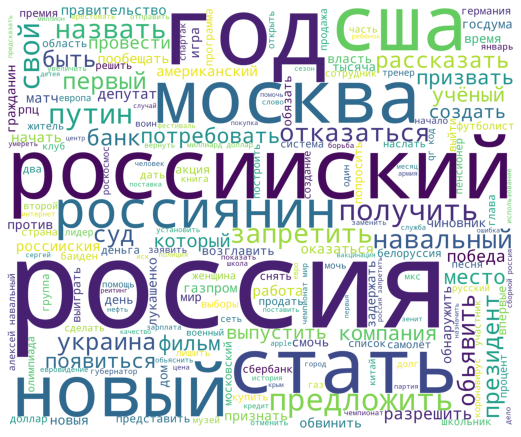

In [41]:
fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(cloud_clean)
plt.axis('off')
plt.subplot(1, 2, 1)

In [42]:
# Количество уникальных слов в очищенном тексте
num_words_clean = len(set(news_clean))
print(f'Количество уникальных слов в исходном тексте: {num_words_clean}')

Количество уникальных слов в исходном тексте: 11778


In [43]:
# df_train_ortho.head()

In [44]:
# Сохраним обработанный вариант датасета df_train
df_train_ortho.to_csv(PREP_DATASET_PATH, index=False, encoding='utf-8')

**Общий вывод:**   
После очистки текста от стоп-слов, количество уникальных слов уменьшилось с 20701 до 11778, т.е. почти на 43%. Также была выполнено приведение текста к стандартному виду и подчищена пунктуация, исправление орфографии.

## Векторное представление текста<a class="anchor" id="vector_representation"></a> 

### Разделение df_train на train и test<a class="anchor" id="train/test_split"></a> 

In [45]:
df_train_prep = pd.read_csv(PREP_DATASET_PATH)
df_train_prep.head()

,title,is_fake,title_len,punct%,title_clean
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1,68,0.0,москвич владимир клутина прийти счёт вмешатель...
1,Агент Кокорина назвал езду по встречке житейск...,0,50,0.0,агент кокорин назвать езда встречка житеиской ...
2,Госдума рассмотрит возможность введения секрет...,1,68,0.0,госдума рассмотреть возможность введение секре...
3,ФАС заблокировала поставку скоростных трамваев...,0,51,0.0,фас заблокировать поставка скоростной трамвай ...
4,Против Навального завели дело о недоносительст...,1,52,0.0,против навальный завести дело недоносительство...


In [46]:
columns = ['title', 'title_clean', 'title_len', 'punct%', 'is_fake']
df_train_prep = df_train_prep.reindex(columns=columns)

In [47]:
X=df_train_prep[['title_clean', 'title_len', 'punct%']]
y=df_train_prep['is_fake']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

In [48]:
print(len(X_train), len(X_test))

4606 1152


### Bag of words (BOW)<a class="anchor" id="bow"></a> 

In [49]:
bow_vect = CountVectorizer()

bow_train = bow_vect.fit_transform(X_train['title_clean'])
bow_test = bow_vect.transform(X_test['title_clean'])

X_train_BOW = pd.concat([X_train[['title_len', 'punct%']].reset_index(drop=True),
                        pd.DataFrame(bow_train.toarray())], axis=1)
X_test_BOW = pd.concat([X_test[['title_len', 'punct%']].reset_index(drop=True),
                        pd.DataFrame(bow_test.toarray())], axis=1)
print(X_train_BOW.shape, X_test_BOW.shape)

(4606, 10400) (1152, 10400)


### TF-IDF<a class="anchor" id="tfidf"></a> 

In [50]:
tfidf_vect = TfidfVectorizer()

tfidf_train = tfidf_vect.fit_transform(X_train['title_clean'])
tfidf_test = tfidf_vect.transform(X_test['title_clean'])

X_train_TFIDF = pd.concat([X_train[['title_len', 'punct%']].reset_index(drop=True),
                        pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_TFIDF = pd.concat([X_test[['title_len', 'punct%']].reset_index(drop=True),
                        pd.DataFrame(tfidf_test.toarray())], axis=1)

print(X_train_TFIDF.shape, X_test_TFIDF.shape)

(4606, 10400) (1152, 10400)


### Bag of words (BOW) с биграммами<a class="anchor" id="bow_bi"></a> 

In [51]:
bow_bi_vect = CountVectorizer(ngram_range=(1, 2))

bow_bi_train = bow_bi_vect.fit_transform(X_train['title_clean'])
bow_bi_test = bow_bi_vect.transform(X_test['title_clean'])

X_train_BOW_bi = pd.concat([X_train[['title_len', 'punct%']].reset_index(drop=True),
                        pd.DataFrame(bow_bi_train.toarray())], axis=1)
X_test_BOW_bi = pd.concat([X_test[['title_len', 'punct%']].reset_index(drop=True),
                        pd.DataFrame(bow_bi_test.toarray())], axis=1)

print(X_train_BOW_bi.shape, X_test_BOW_bi.shape)

(4606, 36074) (1152, 36074)


In [52]:
X_train_BOW_bi.head()

,title_len,punct%,0,1,2,3,4,5,6,7,...,36062,36063,36064,36065,36066,36067,36068,36069,36070,36071
0,77,2.6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,52,1.9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,39,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,39,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,70,2.9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
X_test_BOW_bi.head()

,title_len,punct%,0,1,2,3,4,5,6,7,...,36062,36063,36064,36065,36066,36067,36068,36069,36070,36071
0,53,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,46,2.2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,51,2.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,61,3.3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,42,2.4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Построение моделей<a class="anchor" id="modeling"></a> 

### На данных BOW<a class="anchor" id="modeling_bow"></a> 

In [54]:
%%time
stata_BOW, models_BOW = run_experiment(X_train_BOW, X_test_BOW, y_train, y_test, vector='bow')
stata_BOW

[08:33:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 5min 3s, sys: 1.98 s, total: 5min 5s
Wall time: 1min 5s


,model_name,f1_macro_train_bow,f1_macro_test_bow,f1_0_train_bow,f1_0_test_bow,f1_1_train_bow,f1_1_test_bow
0,lr,0.977631,0.873254,0.978015,0.874355,0.977248,0.872154
1,sgd,0.781697,0.777536,0.790134,0.784874,0.773261,0.770197
2,knb,0.841484,0.766484,0.843549,0.765066,0.839419,0.767903
3,rf,1.000000,0.853821,1.000000,0.860927,1.000000,0.846715
4,xgb,0.882106,0.836419,0.889298,0.844371,0.874913,0.828467


### На данных TF-IDF<a class="anchor" id="modeling_tfidf"></a> 

In [55]:
%%time
stata_TFIDF, models_TFIDF = run_experiment(X_train_TFIDF, X_test_TFIDF, y_train, y_test, vector='tfidf')
stata_TFIDF

[08:34:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 5min 4s, sys: 2.34 s, total: 5min 6s
Wall time: 1min 7s


,model_name,f1_macro_train_tfidf,f1_macro_test_tfidf,f1_0_train_tfidf,f1_0_test_tfidf,f1_1_train_tfidf,f1_1_test_tfidf
0,lr,0.905011,0.851409,0.908290,0.856182,0.901732,0.846637
1,sgd,0.752214,0.760313,0.748179,0.755319,0.756249,0.765306
2,knb,0.832173,0.772322,0.840735,0.779832,0.823610,0.764811
3,rf,1.000000,0.841428,1.000000,0.851064,1.000000,0.831793
4,xgb,0.891954,0.832110,0.898194,0.839834,0.885714,0.824386


### На данных BOW с биграммами<a class="anchor" id="modeling_bow_bi"></a> 

In [56]:
%%time
stata_BOW_bi, models_BOW_bi = run_experiment(X_train_BOW_bi, X_test_BOW_bi, y_train, y_test, vector='bow_bi')
stata_BOW_bi

[08:36:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 16min 52s, sys: 4.26 s, total: 16min 56s
Wall time: 3min 31s


,model_name,f1_macro_train_bow_bi,f1_macro_test_bow_bi,f1_0_train_bow_bi,f1_0_test_bow_bi,f1_1_train_bow_bi,f1_1_test_bow_bi
0,lr,0.994137,0.875852,0.994200,0.877253,0.994075,0.874451
1,sgd,0.746056,0.766505,0.720695,0.746439,0.771417,0.786571
2,knb,0.828438,0.738671,0.831269,0.742074,0.825607,0.735268
3,rf,0.999783,0.845768,0.999784,0.855274,0.999782,0.836263
4,xgb,0.884506,0.837187,0.891527,0.846091,0.877485,0.828283


### Объединение результатов, выбор лучшей модели<a class="anchor" id="stata_combined"></a> 

In [57]:
stata_combined = stata_BOW.merge(stata_TFIDF, on='model_name').merge(stata_BOW_bi, on='model_name')

stata_combined.head()

,model_name,f1_macro_train_bow,f1_macro_test_bow,f1_0_train_bow,f1_0_test_bow,f1_1_train_bow,f1_1_test_bow,f1_macro_train_tfidf,f1_macro_test_tfidf,f1_0_train_tfidf,f1_0_test_tfidf,f1_1_train_tfidf,f1_1_test_tfidf,f1_macro_train_bow_bi,f1_macro_test_bow_bi,f1_0_train_bow_bi,f1_0_test_bow_bi,f1_1_train_bow_bi,f1_1_test_bow_bi
0,lr,0.977631,0.873254,0.978015,0.874355,0.977248,0.872154,0.905011,0.851409,0.908290,0.856182,0.901732,0.846637,0.994137,0.875852,0.994200,0.877253,0.994075,0.874451
1,sgd,0.781697,0.777536,0.790134,0.784874,0.773261,0.770197,0.752214,0.760313,0.748179,0.755319,0.756249,0.765306,0.746056,0.766505,0.720695,0.746439,0.771417,0.786571
2,knb,0.841484,0.766484,0.843549,0.765066,0.839419,0.767903,0.832173,0.772322,0.840735,0.779832,0.823610,0.764811,0.828438,0.738671,0.831269,0.742074,0.825607,0.735268
3,rf,1.000000,0.853821,1.000000,0.860927,1.000000,0.846715,1.000000,0.841428,1.000000,0.851064,1.000000,0.831793,0.999783,0.845768,0.999784,0.855274,0.999782,0.836263
4,xgb,0.882106,0.836419,0.889298,0.844371,0.874913,0.828467,0.891954,0.832110,0.898194,0.839834,0.885714,0.824386,0.884506,0.837187,0.891527,0.846091,0.877485,0.828283


In [58]:
stata_combined.describe()[
    ['f1_macro_test_bow', 'f1_macro_test_tfidf', 'f1_macro_test_bow_bi',     
     'f1_0_test_bow', 'f1_0_test_tfidf', 'f1_0_test_bow_bi',
     'f1_1_test_bow', 'f1_1_test_tfidf', 'f1_1_test_bow_bi'
     ]
]

,f1_macro_test_bow,f1_macro_test_tfidf,f1_macro_test_bow_bi,f1_0_test_bow,f1_0_test_tfidf,f1_0_test_bow_bi,f1_1_test_bow,f1_1_test_tfidf,f1_1_test_bow_bi
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.821503,0.811516,0.812797,0.825918,0.816446,0.813426,0.817087,0.806587,0.812167
std,0.047184,0.042037,0.057653,0.048218,0.045830,0.064169,0.046523,0.038747,0.053123
min,0.766484,0.760313,0.738671,0.765066,0.755319,0.742074,0.767903,0.764811,0.735268
25%,0.777536,0.772322,0.766505,0.784874,0.779832,0.746439,0.770197,0.765306,0.786571
50%,0.836419,0.832110,0.837187,0.844371,0.839834,0.846091,0.828467,0.824386,0.828283
75%,0.853821,0.841428,0.845768,0.860927,0.851064,0.855274,0.846715,0.831793,0.836263
max,0.873254,0.851409,0.875852,0.874355,0.856182,0.877253,0.872154,0.846637,0.874451


In [59]:
stata_combined.sort_values('f1_0_test_bow_bi', ascending=False).iloc[0]

model_name                     lr
f1_macro_train_bow       0.977631
f1_macro_test_bow        0.873254
f1_0_train_bow           0.978015
f1_0_test_bow            0.874355
f1_1_train_bow           0.977248
f1_1_test_bow            0.872154
f1_macro_train_tfidf     0.905011
f1_macro_test_tfidf      0.851409
f1_0_train_tfidf          0.90829
f1_0_test_tfidf          0.856182
f1_1_train_tfidf         0.901732
f1_1_test_tfidf          0.846637
f1_macro_train_bow_bi    0.994137
f1_macro_test_bow_bi     0.875852
f1_0_train_bow_bi          0.9942
f1_0_test_bow_bi         0.877253
f1_1_train_bow_bi        0.994075
f1_1_test_bow_bi         0.874451
Name: 0, dtype: object

**Вывод**:  
По итогам сравнения, лучший результат показала модель LogisticRegression на данных BOW c биграммами. В дальнейшем проведем для нее отбор фичей и подбор гиперпараметров.

In [60]:
%%time

model = models_BOW_bi['lr']

evaluate_preds(model, X_train_BOW_bi, X_test_BOW_bi, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2317
           1       1.00      0.99      0.99      2289

    accuracy                           0.99      4606
   macro avg       0.99      0.99      0.99      4606
weighted avg       0.99      0.99      0.99      4606

TEST

              precision    recall  f1-score   support

           0       0.85      0.91      0.88       562
           1       0.91      0.84      0.87       590

    accuracy                           0.88      1152
   macro avg       0.88      0.88      0.88      1152
weighted avg       0.88      0.88      0.88      1152

CONFUSION MATRIX

col_0      0    1
is_fake          
0        511   51
1         92  498
CPU times: user 1.6 s, sys: 116 ms, total: 1.72 s
Wall time: 699 ms


## Подбор гиперпараметров и отбор фичей<a class="anchor" id="selection_hyperparameters_and_features"></a>

### Отбор фичей<a class="anchor" id="selection_features"></a>

In [61]:
lsvc = LinearSVC(C=0.5) # C=0.5
selective_model = SelectFromModel(lsvc, max_features = None)

X_train_BOW_bi_select_features = selective_model.fit_transform(X_train_BOW_bi, y_train)
X_test_BOW_bi_select_features = selective_model.transform(X_test_BOW_bi)

print('\nNew shapes: ', X_train_BOW_bi.shape, X_test_BOW_bi.shape)
print('\nNew shapes: ', X_train_BOW_bi_select_features.shape, X_test_BOW_bi_select_features.shape)


New shapes:  (4606, 36074) (1152, 36074)

New shapes:  (4606, 14742) (1152, 14742)


In [62]:
clf = models_BOW_bi['lr']
scores = cross_val_score(clf, X_train_BOW_bi_select_features, y_train, cv=5, scoring='accuracy')
print(clf, '\n Cross-validate:', scores)

LogisticRegression(random_state=42) 
 Cross-validate: [0.85574837 0.86427796 0.84473398 0.87839305 0.84581976]


In [63]:
%%time

# обучаем классификатор LogisticRegression
clf = clf.fit(X_train_BOW_bi_select_features, y_train)

# вычисляем предсказания
evaluate_preds(clf, X_train_BOW_bi_select_features, X_test_BOW_bi_select_features, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2317
           1       1.00      1.00      1.00      2289

    accuracy                           1.00      4606
   macro avg       1.00      1.00      1.00      4606
weighted avg       1.00      1.00      1.00      4606

TEST

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       562
           1       0.88      0.82      0.85       590

    accuracy                           0.85      1152
   macro avg       0.85      0.85      0.85      1152
weighted avg       0.85      0.85      0.85      1152

CONFUSION MATRIX

col_0      0    1
is_fake          
0        494   68
1        108  482
CPU times: user 12.9 s, sys: 20.7 ms, total: 13 s
Wall time: 3.28 s


**Вывод:** Точность модели уменьшилась.

### Подбор оптимального размера выборки, кривая обучения<a class="anchor" id="learning_curve"></a>

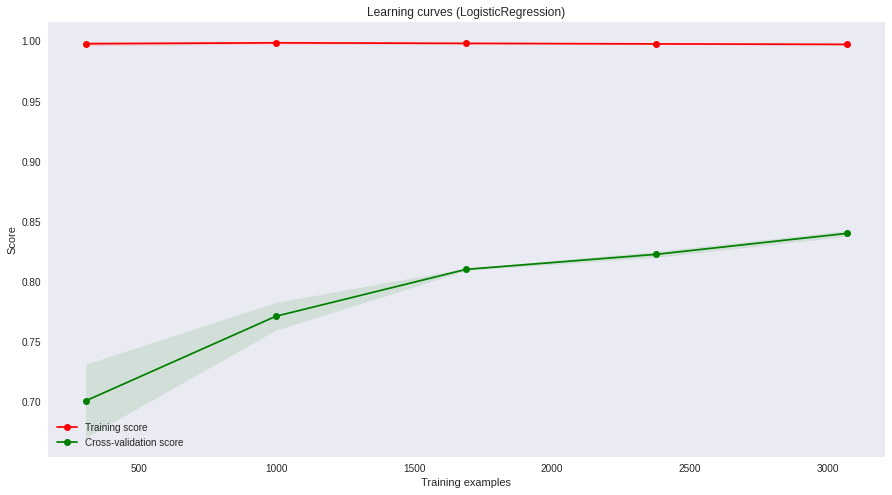

CPU times: user 599 ms, sys: 295 ms, total: 895 ms
Wall time: 18.2 s


In [64]:
%%time
show_learning_curve_plot(clf, X_train_BOW_bi_select_features, y_train)

**Вывод:**  
На всём протяжении кривые сближаются, поэтому обрезать выборку нет необходимости.

### Подбор гиперпараметров<a class="anchor" id="selection_hyperparameters"></a>

In [65]:
# %%time 

# grid = {
#     'max_iter':[100, 150, 200],                                       
#     'C':np.logspace(-3, 3, 4),
#     'penalty':['l1', 'l2'],
#     'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
#     }

# clf=LogisticRegression()
# logreg_cv=GridSearchCV(clf, grid, cv=5)
# logreg_cv.fit(X_train_BOW_bi_select_features, y_train)

# print('tuner hyperparameters: (best parameters) ', logreg_cv.best_params_)
# print('accuracy: ', logreg_cv.best_score_)
# # Ответ:
# # tuner hyperparameters: (best parameters)  {'C': 1000.0, 'max_iter': 150, 'penalty': 'l2', 'solver': 'sag'}
# # accuracy:  0.8666958719302089
# # CPU times: user 3h 17min 53s, sys: 1min 7s, total: 3h 19min 1s
# # Wall time: 2h 55min 44s

tuner hyperparameters: (best parameters)  {'C': 1000.0, 'max_iter': 150, 'penalty': 'l2', 'solver': 'sag'}
accuracy:  0.8666958719302089
CPU times: user 3h 17min 53s, sys: 1min 7s, total: 3h 19min 1s
Wall time: 2h 55min 44s


In [66]:
# logreg_cv.best_params_
# # {'C': 1000.0, 'max_iter': 150, 'penalty': 'l2', 'solver': 'sag'}

{'C': 1000.0, 'max_iter': 150, 'penalty': 'l2', 'solver': 'sag'}

In [67]:
BEST_PARAMS={
    'C': 1000.0,
    'max_iter': 10000,
    'penalty': 'l2',
    'solver': 'liblinear',
    'n_jobs': -1,
    'random_state': RANDOM_STATE
    }

In [68]:
%%time

# обучаем классификатор LogisticRegression
model_bp = LogisticRegression(**BEST_PARAMS).fit(X_train_BOW_bi, y_train)

# вычисляем предсказания
evaluate_preds(model_bp, X_train_BOW_bi, X_test_BOW_bi, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2317
           1       1.00      1.00      1.00      2289

    accuracy                           1.00      4606
   macro avg       1.00      1.00      1.00      4606
weighted avg       1.00      1.00      1.00      4606

TEST

              precision    recall  f1-score   support

           0       0.85      0.92      0.88       562
           1       0.91      0.85      0.88       590

    accuracy                           0.88      1152
   macro avg       0.88      0.88      0.88      1152
weighted avg       0.88      0.88      0.88      1152

CONFUSION MATRIX

col_0      0    1
is_fake          
0        515   47
1         90  500
CPU times: user 3.24 s, sys: 348 ms, total: 3.58 s
Wall time: 2.16 s


**Вывод:**
Уменьшение числа фичей принесло отрицательный результат. Точность упала на 0,03. Если бы, это повлекло за собой прирост в скорости, то, наверное, на это можно было бы пойти.  
Однако, за счёт подбора лучших параметров, получилось добиться уменьшения скорости работы модели с 12,5с до 2,2с. При этом количество фичей сохранено.

###  Построение финальной модели <a class="anchor" id="final_model"></a>

In [69]:
%%time

# обучаем классификатор LogisticRegression
final_model = model_bp

# вычисляем предсказания
evaluate_preds(model_bp, X_train_BOW_bi, X_test_BOW_bi, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2317
           1       1.00      1.00      1.00      2289

    accuracy                           1.00      4606
   macro avg       1.00      1.00      1.00      4606
weighted avg       1.00      1.00      1.00      4606

TEST

              precision    recall  f1-score   support

           0       0.85      0.92      0.88       562
           1       0.91      0.85      0.88       590

    accuracy                           0.88      1152
   macro avg       0.88      0.88      0.88      1152
weighted avg       0.88      0.88      0.88      1152

CONFUSION MATRIX

col_0      0    1
is_fake          
0        515   47
1         90  500
CPU times: user 1.78 s, sys: 128 ms, total: 1.91 s
Wall time: 644 ms


### Сохранение финальной модели<a class="anchor" id="final_model_saving"></a>

In [70]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

## Прогнозирование на тестовом датасете<a class="anchor" id="forecasting_test_dataset"></a>

### Подготовка тестовых данных<a class="anchor" id="test_dataset_processing"></a>

In [87]:
%%time

# Проверка орфографии
df_test['title'] = df_test['title'].apply(get_spelling_check_text)

CPU times: user 28 s, sys: 1.24 s, total: 29.2 s
Wall time: 4min 17s


In [88]:
df_test.to_csv(PRED_ORTHO_DATASET_PATH, index=False, encoding='utf-8')

In [89]:
df_test = pd.read_csv(PRED_ORTHO_DATASET_PATH)

In [90]:
# df_test.head()

In [91]:
%%time

# Предварительная обработка текста
df_test['title'] = df_test['title'].apply(get_text_preprocessing)

CPU times: user 1min 6s, sys: 6.37 s, total: 1min 12s
Wall time: 1min 12s


In [92]:
df_test.to_csv(PRED_PREP_DATASET_PATH, index=False, encoding='utf-8')

In [93]:
df_test = pd.read_csv(PRED_PREP_DATASET_PATH)

In [94]:
df_test.head()

,title,is_fake,title_len,punct%
0,роскомнадзор представить реестр сочетание цвет...,0,61,0.0
1,ночью минския президентской гора беларашмор пи...,0,89,0.0
2,бывший спичраитер юрий лоза рассказать труднос...,0,60,0.0
3,сельския церковь собрать рекордно низкия колич...,0,86,0.0
4,акция google рухнуть обьявление перезапуск rutube,0,44,0.0


In [95]:
# функция для вычисления длины заголовка новости без учета пробелов
df_test['title_len'] = df_test['title'].apply(lambda x: len(x) - x.count(" "))

# функция показывает процент знаков препинания в теле заголовка новости
df_test['punct%'] = df_test['title'].apply(lambda x: count_punct(x))

df_test.head()

,title,is_fake,title_len,punct%
0,роскомнадзор представить реестр сочетание цвет...,0,61,0.0
1,ночью минския президентской гора беларашмор пи...,0,89,0.0
2,бывший спичраитер юрий лоза рассказать труднос...,0,60,0.0
3,сельския церковь собрать рекордно низкия колич...,0,86,0.0
4,акция google рухнуть обьявление перезапуск rutube,0,44,0.0


In [96]:
# Векторное представление текста (Bag of words (BOW) с биграммами)

X_pred_BOW_bi = bow_bi_vect.transform(df_test['title'])

df_test_vect = pd.concat([df_test[['title_len', 'punct%']].reset_index(drop=True),
                        pd.DataFrame(X_pred_BOW_bi.toarray())], axis=1)

print(X_pred_BOW_bi.shape)

(1000, 36072)


In [97]:
df_test_vect.head(10)

,title_len,punct%,0,1,2,3,4,5,6,7,...,36062,36063,36064,36065,36066,36067,36068,36069,36070,36071
0,61,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,89,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,60,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,86,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,44,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,37,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,38,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,45,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,46,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,41,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Прогноз<a class="anchor" id="forecast"></a>

In [98]:
%%time

# Обучение финальной модели
# final_model.fit(X_train_BOW_bi, y_train)

# Прогнозирование на тестовом датасете
y_predict = final_model.predict(df_test_vect)

CPU times: user 261 ms, sys: 48 ms, total: 309 ms
Wall time: 277 ms


In [99]:
y_predict.shape

(1000,)

### Сохранение результатов<a class="anchor" id="saving_results"></a>

In [100]:
predictions = pd.read_csv(TEST_DATASET_PATH, sep='\t')
predictions['is_fake'] = y_predict
predictions.to_csv(SUBMISSION_PATH, sep='\t', index=False)

In [101]:
# Посмотрим, что получилось
predictions

,title,is_fake
0,Роскомнадзор представил реестр сочетаний цвето...,1
1,Ночью под Минском на президентской горе Белара...,1
2,Бывший спичрайтер Юрия Лозы рассказал о трудно...,1
3,"Сельская церковь, собравшая рекордно низкое ко...",1
4,Акции Google рухнули после объявления о переза...,0
...,...,...
995,Прокуратура заподозрила Явлинского в авторитар...,0
996,В День Победы стратегические ракетоносцы Ту-16...,1
997,СК возбудил дело против авиакомпании «Победа» ...,1
998,Криптомонетный двор Туркменистана выпустил юби...,1


In [102]:
predictions['is_fake'].value_counts()

0    597
1    403
Name: is_fake, dtype: int64

## Итоги работы<a class="anchor" id="results"></a>

Целью задания была разработка модели, которая будет способна различать заголовки реальных и выдуманных новостей.  
Для оценки финального решения используется метрика F1 score. Также оценивается чистота кода, оформление и понятность исследования.  
Для обучения модели были использованы данные из файла *train.tsv*. В файле находится таблица, состоящая из двух колонок и 5758 строк. Количество уникальных слов — 20701. В колонке **«title»** записан заголовок новости. В колонке **«is_fake»** содержатся метки: 0 – новость реальная; 1 – новость выдуманная. Файл *test.tsv*, на котором предстоит осуществлять предсказание, аналогичен по количеству колонок и имеет 1000 строк.  
В ходе анализа данных было установлено, что в датасетах отсутствуют пропуски. Целевая переменная **«is_fake»** в датасете  *train.tsv* сбалансирована по классам: "1"  встречается 2879 и "0" встречается также 2879. Была определена длина текстовых сообщений и процент знаков препинания в них. Вымышленные новости имеют большую длину, чем реальные, но это различие не явно выраженное. Анализ процента знаков препинания нзначимых результатов не дал. Есть один повтор в строках 402 и 624, что маловероятно может сказаться на конечном результате, т.к. соответствующее данным строкам значение «is_fake» одинаковое. Скорее всего, это просто опечатка. Было построено облако слов, из которого сразу стало видно большое количетво «мусорных» слов.  
Была выполнена предварительная обработка данных, в ходе которой была проведена проверка орфографии, очистка текста от «мусора» и приведение слов к стандартному виду, удаление пунктуации. Здесь применялось два подхода: лемматизация и стемминг. Леммитация, хоть и дольше по времени, но показала себя лучше. После обработки количество уникальных слов снизилось до 11778, что на 43% меньше.  
Для векторного представления текста использовались три подхода: Bag of words (BOW), TF-IDF,  и Bag of words (BOW) с биграммами (ngram_range=(1, 2)). На их основе строились 5 моделей: LogisticRegression, SGDClassifier, KNeighborsClassifier, RandomForestClassifier и XGBClassifier. По итогам сравнения, была выбрана модель  LogisticRegression, обученная на данных  Bag of words (BOW) с биграммами. Она показала точность 0 — 88% и 1 — 87%.  
Отбор фич с помощью LinearSVC положительных результатов не дал: точность упала на 3%. Поэтому от него отказался. Подбор гиперпараметров по сетке GridSearchCV также не добавил существенного прироста. Только уменьшение времени работы модели с с 12,5с до 2,2с. Однако, при увеличении 'max_iter' до 10000, удалось немного улучшить результат, если судить по матрице ошибок.  
В ходе прогнозирования на тестовом датасете  test.tsv, были проведены те же процедуры по очистке, что и на тренировочном и использовалась лучшая модель с лучшими параметрами. Результатом предсказания стало отнесения 597 новостей к реальным (класс 0) и 403 к выдуманным (класс 1).